# DCGAN - Conditional Control - Dataset: CELEBA

### Packages and Visualization

In [1]:
from torchvision.utils import make_grid
from torch.utils.data import DataLoader
from torchvision.datasets import CelebA
from torchvision import transforms
import torch.nn.functional as F
import matplotlib.pyplot as plt
from tqdm.auto import tqdm
from torch import nn
import torch

### Utility Function for Viewing Images

In [2]:
dataset_size = (3, 64, 64)

def show_tensor_images(image_tensor, num_images = 25, size = dataset_size, nrow = 5, show = True):
    '''
    Function for visualizing images: Given a tensor of images, number of images, and
    size per image, plots and prints the images in an uniform grid.
    '''
    
    image_tensor = (image_tensor + 1) / 2
    image_unflat = image_tensor.detach().cpu()
    image_grid = make_grid(tensor = image_unflat[:num_images], nrow = nrow)
    plt.imshow(image_grid.permute(1, 2, 0).squeeze())
    if show:
        plt.show()

### Generator and Noise

In [3]:
class Generator(nn.Module):
    '''
    Generator Class
    Values:
        input_dim: the dimension of the input vector, a scalar
        im_chan: the number of channels in the images, fitted for the dataset used, a scalar
        hidden_dim: the inner dimension, a scalar
    '''
    
    def __init__(self, input_dim = 10, im_chan = 3, hidden_dim = 64):
        super(Generator, self).__init__()
        
        self.input_dim = input_dim
        
        # Build the neural network
        self.gen = nn.Sequential(
            self.make_gen_block(input_channels = input_dim, output_channels = hidden_dim * 8, 
                                kernel_size = 4, stride = 1, padding = 0, bias = False),
            self.make_gen_block(input_channels = hidden_dim * 8, output_channels = hidden_dim * 4, 
                                kernel_size = 4, stride = 2, padding = 1, bias = False),
            self.make_gen_block(input_channels = hidden_dim * 4, output_channels = hidden_dim * 2,
                                kernel_size = 4, stride = 2, padding = 1, bias = False),
            self.make_gen_block(input_channels = hidden_dim * 2, output_channels = hidden_dim,
                                kernel_size = 4, stride = 2, padding = 1, bias = False),
            self.make_gen_block(input_channels = hidden_dim, output_channels = im_chan, 
                                kernel_size = 4, stride = 2, padding = 1, bias = False, 
                                final_layer = True))

    def make_gen_block(self, input_channels, output_channels, kernel_size = 3, stride = 2, 
                       padding = 1, bias = False, final_layer = False):
        '''
        Function to return a sequence of operations corresponding to a generator block of DCGAN;
        a transposed convolution, a batchnorm (except in the final layer), and an activation.
        Parameters:
            input_channels: how many channels the input feature representation has
            output_channels: how many channels the output feature representation should have
            kernel_size: the size of each convolutional filter, equivalent to (kernel_size, kernel_size)
            stride: the stride of the convolution
            final_layer: a boolean, true if it is the final layer and false otherwise 
                         (affects activation and batchnorm)
        '''
        
        if not final_layer:
            return nn.Sequential(
                nn.ConvTranspose2d(in_channels = input_channels, out_channels = output_channels, 
                                   kernel_size = kernel_size, stride = stride, padding = padding,
                                   bias = bias),
                nn.BatchNorm2d(num_features = output_channels),
                nn.ReLU(inplace = True))
        else:
            return nn.Sequential(
                nn.ConvTranspose2d(in_channels = input_channels, out_channels = output_channels,
                                   kernel_size = kernel_size, stride = stride, padding = padding,
                                   bias = bias),
                nn.Tanh())

    def forward(self, noise):
        '''
        Function for completing a forward pass of the generator: Given a noise tensor, 
        returns generated images.
        Parameters:
            noise: a noise tensor with dimensions (n_samples, input_dim)
        '''
        
        x = noise.view(len(noise), self.input_dim, 1, 1)
        return self.gen(x)

In [4]:
def get_noise(n_samples, input_dim, device = 'cpu'):
    '''
    Function for creating noise vectors: Given the dimensions (n_samples, input_dim)
    creates a tensor of that shape filled with random numbers from the normal distribution.
    Parameters:
        n_samples: the number of samples to generate, a scalar
        input_dim: the dimension of the input vector, a scalar
        device: the device type
    '''
    
    return torch.randn(n_samples, input_dim, device = device)

### Discriminator

In [5]:
class Discriminator(nn.Module):
    '''
    Discriminator Class
    Values:
      im_chan: the number of channels in the images, fitted for the dataset used, a scalar
      hidden_dim: the inner dimension, a scalar
    '''
    
    def __init__(self, im_chan = 3, hidden_dim = 64):
        super(Discriminator, self).__init__()
        self.disc = nn.Sequential(
            self.make_disc_block(input_channels = im_chan, output_channels = hidden_dim, 
                                 kernel_size = 4, stride = 2, padding = 1, bias = False, 
                                 first_layer = True),
            self.make_disc_block(input_channels = hidden_dim, output_channels = hidden_dim * 2, 
                                 kernel_size = 4, stride = 2, padding = 1, bias = False),
            self.make_disc_block(input_channels = hidden_dim * 2, output_channels = hidden_dim * 4, 
                                 kernel_size = 4, stride = 2, padding = 1, bias = False),
            self.make_disc_block(input_channels = hidden_dim * 4, output_channels = hidden_dim * 8, 
                                 kernel_size = 4, stride = 2, padding = 1, bias = False),
            self.make_disc_block(input_channels = hidden_dim * 8, output_channels = 1, 
                                 kernel_size = 4, stride = 1, padding = 0, bias = False,
                                 final_layer = True))

    def make_disc_block(self, input_channels, output_channels, kernel_size = 4, stride = 2,
                        padding = 1, bias = False, first_layer = False, final_layer = False):
        '''
        Function to return a sequence of operations corresponding to a discriminator block of the DCGAN; 
        a convolution, a batchnorm (except in the final layer), and an activation (except in the final layer).
        Parameters:
            input_channels: how many channels the input feature representation has
            output_channels: how many channels the output feature representation should have
            kernel_size: the size of each convolutional filter, equivalent to (kernel_size, kernel_size)
            stride: the stride of the convolution
            final_layer: a boolean, true if it is the final layer and false otherwise 
                      (affects activation and batchnorm)
        '''

        if first_layer:
          return nn.Sequential(
                nn.Conv2d(in_channels = input_channels, out_channels = output_channels, 
                          kernel_size = kernel_size, stride = stride, padding = padding,
                          bias = bias),
                nn.LeakyReLU(negative_slope = 0.2, inplace = True)) 
        elif not final_layer:
            return nn.Sequential(
                nn.Conv2d(in_channels = input_channels, out_channels = output_channels, 
                          kernel_size = kernel_size, stride = stride, padding = padding,
                          bias = bias),
                nn.BatchNorm2d(num_features = output_channels),
                nn.LeakyReLU(negative_slope = 0.2, inplace = True)) 
        else:
            return nn.Sequential(
                nn.Conv2d(in_channels = input_channels, out_channels = output_channels, 
                          kernel_size = kernel_size, stride = stride, padding = padding,
                          bias = bias))

    def forward(self, image):
        '''
        Function for completing a forward pass of the discriminator: Given an image tensor, 
        returns a 1-dimension tensor representing fake/real.
        Parameters:
            image: a flattened image tensor with dimension (im_chan)
        '''
        
        disc_pred = self.disc(image)
        return disc_pred.view(len(disc_pred), -1)

### Class Input

In [6]:
def get_one_hot_labels(labels, n_classes):
    '''
    Function for creating one-hot vectors for the labels, returns a tensor of shape (?, num_classes).
    Parameters:
        labels: tensor of labels from the dataloader, size (?)
        n_classes: the total number of classes in the dataset, an integer scalar
    '''
    
    return F.one_hot(labels, n_classes)

In [7]:
def combine_vectors(x, y):
    '''
    Function for combining two vectors with shapes (n_samples, ?) and (n_samples, ?).
    Parameters:
      x: (n_samples, ?) the first vector. 
         In this assignment, this will be the noise vector of shape (n_samples, z_dim), 
         but you shouldn't need to know the second dimension's size.
      y: (n_samples, ?) the second vector.
         Once again, in this assignment this will be the one-hot class vector 
         with the shape (n_samples, n_classes), but you shouldn't assume this in your code.
    '''
    
    combined = torch.cat(tensors = (x.float(), y.float()), dim = 1)
   
    return combined

### Training

In [9]:
celeba_shape = (3, 64, 64)
n_classes = 3

In [25]:
criterion = nn.BCEWithLogitsLoss()
n_epochs = 100
z_dim = 64
display_step = 2500
batch_size = 128
lr = 0.0002
device = 'cuda'

class NewCelebA(CelebA):
    def __getitem__(self, index):

        img, targets = super().__getitem__(index)
        gender_idx = 20
        gender = targets[gender_idx]
  
        return img, 1 if gender == 0 else 2

transform = transforms.Compose([transforms.Resize((64, 64)), transforms.ToTensor(), 
                                transforms.Normalize((0.5,), (0.5,))])

celeba = NewCelebA('.', download = True, transform = transform)

batch_size = 128
dataloader = DataLoader(celeba, batch_size = batch_size, shuffle = True)


Files already downloaded and verified


In [26]:
def get_input_dimensions(z_dim, celeba_shape, n_classes):
    '''
    Function for getting the size of the conditional input dimensions 
    from z_dim, the image shape, and number of classes.
    Parameters:
        z_dim: the dimension of the noise vector, a scalar
        cifar10_shape: the shape of each CIFAR10 image as (C, W, H)
        n_classes: the total number of classes in the dataset, an integer scalar
                   (10 for MNIST)
    Returns: 
        generator_input_dim: the input dimensionality of the conditional generator, 
                             which takes the noise and class vectors
        discriminator_im_chan: the number of input channels to the discriminator
                               (e.g. C x 28 x 28 for MNIST)
    '''

    generator_input_dim = z_dim + n_classes
    discriminator_im_chan = celeba_shape[0] + n_classes

    return generator_input_dim, discriminator_im_chan

In [27]:
generator_input_dim, discriminator_im_chan = get_input_dimensions(z_dim = z_dim,celeba_shape = celeba_shape, 
                                                                  n_classes = n_classes)

gen = Generator(input_dim = generator_input_dim).to(device)
gen_opt = torch.optim.Adam(params = gen.parameters(), lr = lr)
disc = Discriminator(im_chan = discriminator_im_chan).to(device)
disc_opt = torch.optim.Adam(params = disc.parameters(), lr = lr)

def weights_init(m):
    
    if isinstance(m, nn.Conv2d) or isinstance(m, nn.ConvTranspose2d):
        torch.nn.init.normal_(tensor = m.weight, mean = 0.0, std = 0.02)
    if isinstance(m, nn.BatchNorm2d):
        torch.nn.init.normal_(tensor = m.weight, mean = 0.0, std = 0.02)
        torch.nn.init.constant_(tensor = m.bias, val = 0)
        
gen = gen.apply(fn = weights_init)
disc = disc.apply(fn = weights_init)

  0%|          | 0/1272 [00:00<?, ?it/s]

  0%|          | 0/1272 [00:00<?, ?it/s]

Step 2500: Generator loss: 6.322856344604492, discriminator loss: 0.04686760973429773


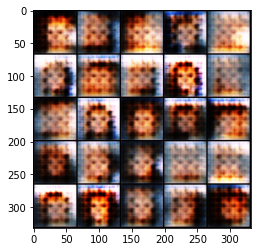

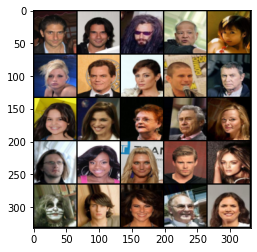

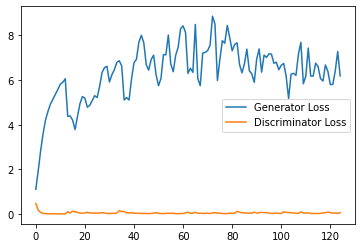

  0%|          | 0/1272 [00:00<?, ?it/s]

  0%|          | 0/1272 [00:00<?, ?it/s]

Step 5000: Generator loss: 6.842996842598915, discriminator loss: 0.048593518010806296


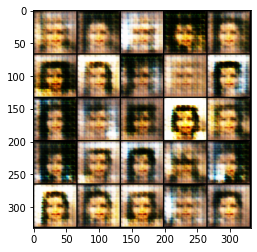

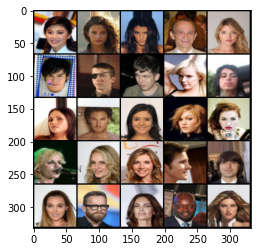

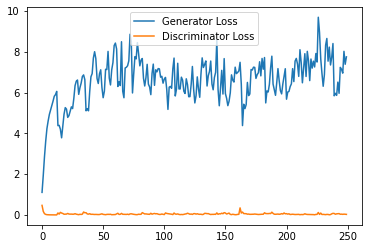

  0%|          | 0/1272 [00:00<?, ?it/s]

  0%|          | 0/1272 [00:00<?, ?it/s]

Step 7500: Generator loss: 7.632506226873398, discriminator loss: 0.04467728824561928


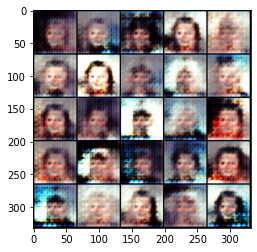

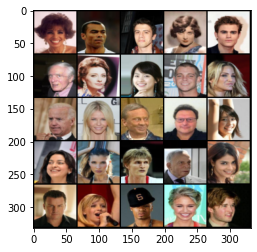

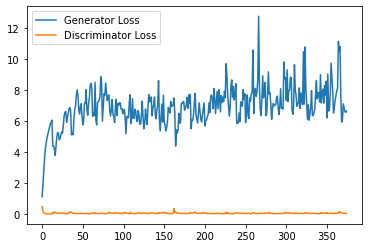

  0%|          | 0/1272 [00:00<?, ?it/s]

  0%|          | 0/1272 [00:00<?, ?it/s]

Step 10000: Generator loss: 7.823318813467026, discriminator loss: 0.04288996610281174


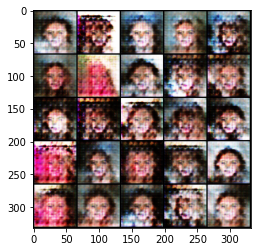

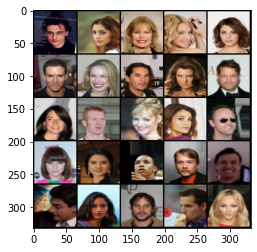

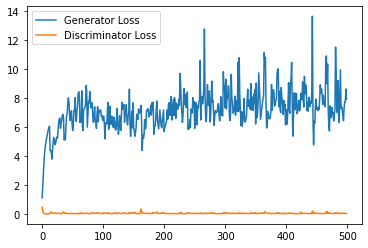

  0%|          | 0/1272 [00:00<?, ?it/s]

  0%|          | 0/1272 [00:00<?, ?it/s]

Step 12500: Generator loss: 8.090500514602661, discriminator loss: 0.04729622563752637


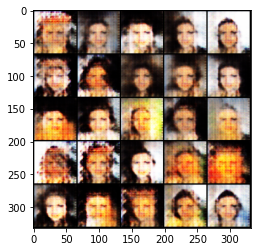

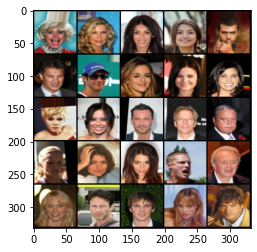

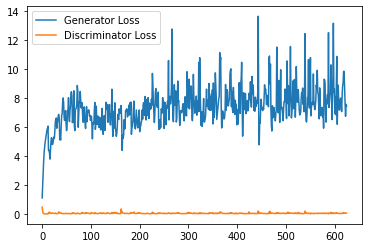

  0%|          | 0/1272 [00:00<?, ?it/s]

  0%|          | 0/1272 [00:00<?, ?it/s]

Step 15000: Generator loss: 8.093303716659547, discriminator loss: 0.04276847272658488


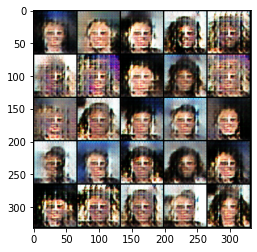

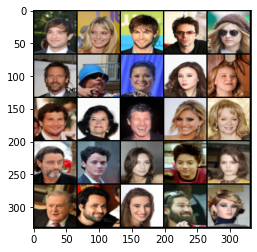

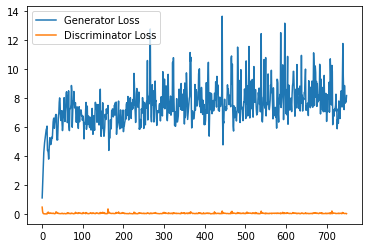

  0%|          | 0/1272 [00:00<?, ?it/s]

  0%|          | 0/1272 [00:00<?, ?it/s]

Step 17500: Generator loss: 7.838035389900208, discriminator loss: 0.05229739706065229


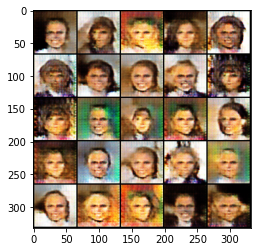

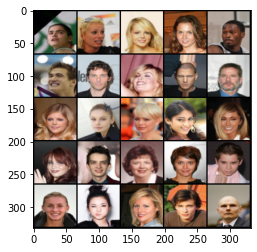

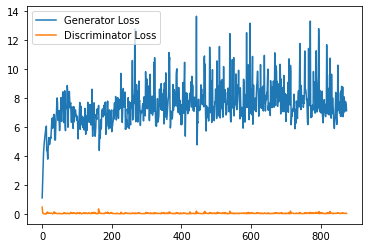

  0%|          | 0/1272 [00:00<?, ?it/s]

  0%|          | 0/1272 [00:00<?, ?it/s]

Step 20000: Generator loss: 7.426446192979813, discriminator loss: 0.05670507315798896


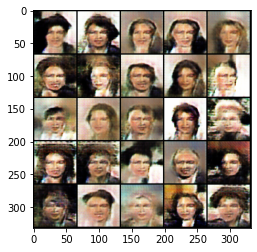

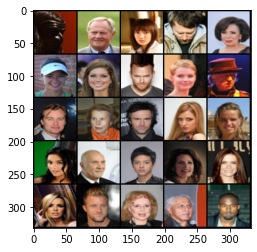

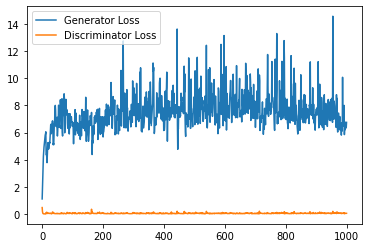

  0%|          | 0/1272 [00:00<?, ?it/s]

  0%|          | 0/1272 [00:00<?, ?it/s]

Step 22500: Generator loss: 6.997894198513031, discriminator loss: 0.06256467821206897


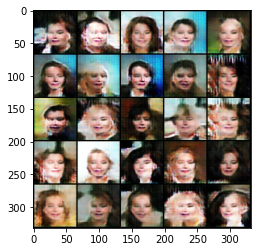

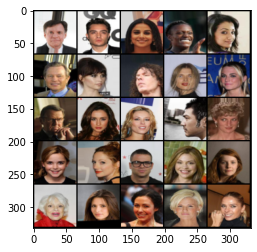

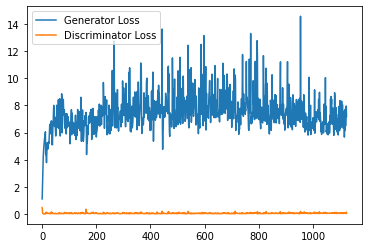

  0%|          | 0/1272 [00:00<?, ?it/s]

In [ ]:
cur_step = 0
generator_losses = []
discriminator_losses = []

# Initializations needed for grading
noise_and_labels = False
fake = False

fake_image_and_labels = False
real_image_and_labels = False
disc_fake_pred = False
disc_real_pred = False

for epoch in range(n_epochs):
    
    # Dataloader returns the batches and the labels
    for real, labels in tqdm(dataloader):
        
        cur_batch_size = len(real)
        # Flatten the batch of real images from the dataset
        real = real.to(device)

        one_hot_labels = get_one_hot_labels(labels = labels.to(device), n_classes = n_classes)
        image_one_hot_labels = one_hot_labels[:, :, None, None]
        image_one_hot_labels = image_one_hot_labels.repeat(1, 1, celeba_shape[1], celeba_shape[2])

        # Update discriminator
        # Zero out the discriminator gradients
        disc_opt.zero_grad()
        # Get noise corresponding to the current batch_size 
        fake_noise = get_noise(n_samples = cur_batch_size, input_dim = z_dim, device = device)
        
        # Get the images from the generator
        noise_and_labels = combine_vectors(x = fake_noise, y = one_hot_labels)
        fake = gen(noise_and_labels)
        
        # Make sure that enough images were generated
        assert len(fake) == len(real)
        # Check that correct tensors were combined
        assert tuple(noise_and_labels.shape) == (cur_batch_size, fake_noise.shape[1] + one_hot_labels.shape[1])
        # It comes from the correct generator
        assert tuple(fake.shape) == (len(real), 3, 64, 64)

        # Get the predictions from the discriminator
        fake_image_and_labels = combine_vectors(x = fake, y = image_one_hot_labels)
        real_image_and_labels = combine_vectors(x = real, y = image_one_hot_labels)
        disc_fake_pred = disc(fake_image_and_labels.detach())
        disc_real_pred = disc(real_image_and_labels)
        
        # Make sure shapes are correct 
        assert tuple(fake_image_and_labels.shape) == (len(real), fake.detach().shape[1] + image_one_hot_labels.shape[1], 64, 64)
        assert tuple(real_image_and_labels.shape) == (len(real), real.shape[1] + image_one_hot_labels.shape[1], 64, 64)
        # Make sure that enough predictions were made
        assert len(disc_real_pred) == len(real)
        # Make sure that the inputs are different
        assert torch.any(fake_image_and_labels != real_image_and_labels)
        # Shapes must match
        assert tuple(fake_image_and_labels.shape) == tuple(real_image_and_labels.shape)
        assert tuple(disc_fake_pred.shape) == tuple(disc_real_pred.shape)
        
        
        disc_fake_loss = criterion(disc_fake_pred, torch.zeros_like(disc_fake_pred))
        disc_real_loss = criterion(disc_real_pred, torch.ones_like(disc_real_pred))
        disc_loss = (disc_fake_loss + disc_real_loss) / 2
        disc_loss.backward(retain_graph=True)
        disc_opt.step() 

        # Keep track of the average discriminator loss
        discriminator_losses += [disc_loss.item()]

        # Update generator
        # Zero out the generator gradients
        gen_opt.zero_grad()

        fake_image_and_labels = combine_vectors(x = fake, y = image_one_hot_labels)
        # This will error if you didn't concatenate your labels to your image correctly
        disc_fake_pred = disc(fake_image_and_labels)
        gen_loss = criterion(disc_fake_pred, torch.ones_like(disc_fake_pred))
        gen_loss.backward()
        gen_opt.step()

        # Keep track of the generator losses
        generator_losses += [gen_loss.item()]

        if cur_step % display_step == 0 and cur_step > 0:
            gen_mean = sum(generator_losses[-display_step:]) / display_step
            disc_mean = sum(discriminator_losses[-display_step:]) / display_step
            print(f"Step {cur_step}: Generator loss: {gen_mean}, discriminator loss: {disc_mean}")
            show_tensor_images(fake)
            show_tensor_images(real)
            step_bins = 20
            x_axis = sorted([i * step_bins for i in range(len(generator_losses) // step_bins)] * step_bins)
            num_examples = (len(generator_losses) // step_bins) * step_bins
            plt.plot(range(num_examples // step_bins), 
                     torch.Tensor(generator_losses[:num_examples]).view(-1, step_bins).mean(1),
                     label = "Generator Loss")
            plt.plot(range(num_examples // step_bins), 
                     torch.Tensor(discriminator_losses[:num_examples]).view(-1, step_bins).mean(1),
                     label = "Discriminator Loss")
            plt.legend()
            plt.show()

        cur_step += 1

### Exploration

In [ ]:
gen = gen.eval()

### Changing the Class Vector

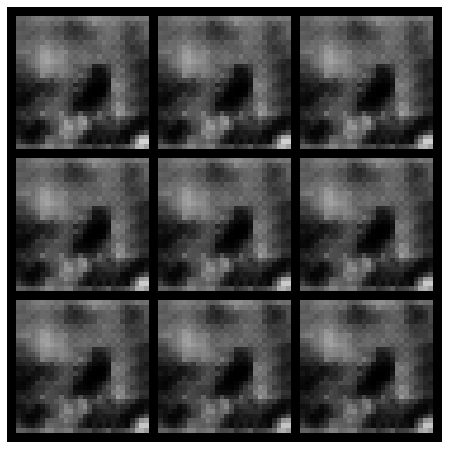

In [ ]:
import math

# Choose the interpolation: how many intermediate images you want + 2 (for the start and end image)
n_interpolation = 9 
interpolation_noise = get_noise(1, z_dim, device = device).repeat(n_interpolation, 1)

def interpolate_class(first_number, second_number):
    first_label = get_one_hot_labels(torch.Tensor([first_number]).long(), n_classes)
    second_label = get_one_hot_labels(torch.Tensor([second_number]).long(), n_classes)

    # Calculate the interpolation vector between the two labels
    percent_second_label = torch.linspace(0, 1, n_interpolation)[:, None]
    interpolation_labels = first_label * (1 - percent_second_label) + second_label * percent_second_label

    # Combine the noise and the labels
    noise_and_labels = combine_vectors(interpolation_noise, interpolation_labels.to(device))
    fake = gen(noise_and_labels)
    show_tensor_images(fake, num_images = n_interpolation, nrow = int(math.sqrt(n_interpolation)), show = False)

# Choose the start digit
start_plot_number = 4
# Choose the end digit
end_plot_number = 6

plt.figure(figsize=(8, 8))
interpolate_class(start_plot_number, end_plot_number)
_ = plt.axis('off')

### Changing the Noise Vector

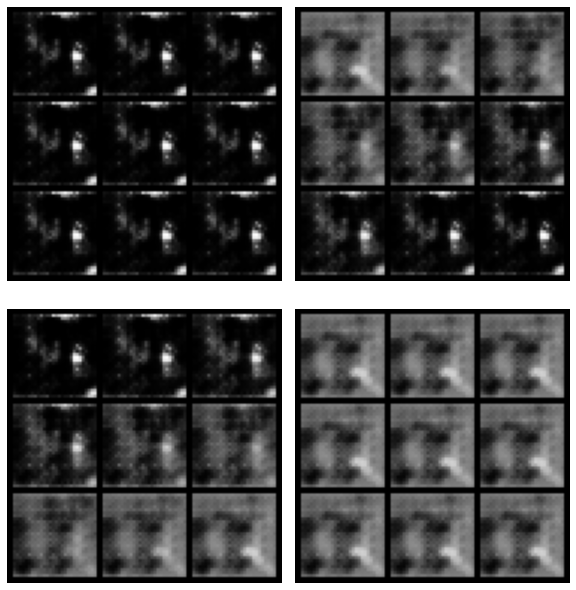

In [ ]:
# How many intermediate images you want + 2 (for the start and end image)
n_interpolation = 9
# Choose the number of noise examples in the grid
n_noise = 2

# This time you're interpolating between the noise instead of the labels
interpolation_label = get_one_hot_labels(torch.Tensor([n_noise]).long(), n_classes).repeat(n_interpolation, 1).float()

def interpolate_noise(first_noise, second_noise):
    # This time you're interpolating between the noise instead of the labels
    percent_first_noise = torch.linspace(0, 1, n_interpolation)[:, None].to(device)
    interpolation_noise = first_noise * percent_first_noise + second_noise * (1 - percent_first_noise)

    # Combine the noise and the labels again
    noise_and_labels = combine_vectors(interpolation_noise, interpolation_label.to(device))
    fake = gen(noise_and_labels)
    show_tensor_images(fake, num_images=n_interpolation, nrow = int(math.sqrt(n_interpolation)), show = False)

# Generate noise vectors to interpolate between
plot_noises = [get_noise(1, z_dim, device=device) for i in range(n_noise)]
plt.figure(figsize=(8, 8))
for i, first_plot_noise in enumerate(plot_noises):
    for j, second_plot_noise in enumerate(plot_noises):
        plt.subplot(n_noise, n_noise, i * n_noise + j + 1)
        interpolate_noise(first_plot_noise, second_plot_noise)
        plt.axis('off')
plt.subplots_adjust(top=1, bottom=0, left=0, right=1, hspace=0.1, wspace=0)
plt.show()
plt.close()

### Save Model

In [ ]:
torch.save(gen.state_dict(), f = 'gen_conditional_dcgan_cifar10.pth')
torch.save(disc.state_dict(), f = 'disc_conditional_dcgan_cifar10.pth')